### Resources
https://docs.dgl.ai/en/0.6.x/api/python/dgl.dataloading.html#dgl.dataloading.pytorch.EdgeDataLoader <br>
https://docs.dgl.ai/en/0.6.x/guide/minibatch-edge.html#guide-minibatch-edge-classification-sampler <br>
https://docs.dgl.ai/en/0.6.x/guide/minibatch-custom-sampler.html#guide-minibatch-customizing-neighborhood-sampler

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import itertools
import matplotlib.pyplot as plt
import dgl
from sklearn import preprocessing

Using backend: pytorch


In [2]:
df = pd.read_csv('data_small/ratings.csv')

In [3]:
df.drop(columns=['timestamp'], inplace=True)

In [4]:
encoders = {
    'user': preprocessing.LabelEncoder(),
    'movie': preprocessing.LabelEncoder(),
}

df['encoded_user'] = encoders['user'].fit_transform(df.userId)
df['encoded_movie'] = encoders['movie'].fit_transform(df.movieId)

df_train, df_val = train_test_split(df, test_size=0.2, stratify = df.rating.values)

In [5]:
df_train.to_csv('split_train.csv')
df_val.to_csv('split_val.csv')

### Train Graph construction
- user nodes will start at index `num_movies`

In [6]:
num_movies = df['encoded_movie'].nunique()
num_users = df['encoded_user'].nunique()

In [7]:
df['encoded_user'] = df['encoded_user']+num_movies

In [8]:
g = dgl.graph((torch.tensor(pd.concat([df_train.encoded_user,df_train.encoded_movie]).tolist()), 
               torch.tensor(pd.concat([df_train.encoded_movie,df_train.encoded_user]).tolist())))

### Model definition

In [9]:
from dgl.nn import SAGEConv

In [10]:
class GNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, out_dim, 'mean')
        self.conv2 = SAGEConv(out_dim, out_dim, 'mean')
        self.conv3 = SAGEConv(out_dim, out_dim, 'mean')
        
    def forward(self, blocks, x):
        h = F.relu(self.conv1(blocks[0], x))
        h = self.conv2(blocks[1], h)
        return h
    
    
class ScorePredictor(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(2*in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1, bias=False)
        )
        
    def apply_edges(self, edges):
        feat = torch.cat([edges.src['h'], edges.dst['h']], dim=1)
        
        return {'score': self.mlp(feat)}
        
    def forward(self, edge_subgraph, x):
        
        with edge_subgraph.local_scope():
            edge_subgraph.ndata['h'] = x
            edge_subgraph.apply_edges(self.apply_edges)
    
            return edge_subgraph.edata['score']
    
    
class Model(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        
        self.conv = GNN(in_dim, hidden_dim)
        self.predictor = ScorePredictor(hidden_dim, hidden_dim)
        
    def forward(self, edge_subgraph, blocks, x):
        
        h = self.conv(blocks, x)
        h = self.predictor(edge_subgraph, h)
        
        return h

#### Data loader

In [11]:
n_edges = g.number_of_edges()
sampler = dgl.dataloading.MultiLayerNeighborSampler(fanouts=[20, 15,])

dataloader = dgl.dataloading.EdgeDataLoader(
    g, 
    torch.arange(0, n_edges), 
    sampler,
    exclude='reverse_id',
    reverse_eids=torch.cat([
        torch.arange(n_edges // 2, n_edges), torch.arange(0, n_edges // 2)]),

    batch_size=1024,
    shuffle=True,
    drop_last=False,
    num_workers=4
    )

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
def compute_loss(labels, predictions):
    return F.mse_loss(labels.float(), predictions.float())

In [14]:
movie_feat = nn.Embedding(num_movies, 64, device=device)
user_feat = nn.Embedding(num_users, 64, device=device)

features = torch.cat([movie_feat.weight, user_feat.weight], dim=0)
labels = torch.tensor(pd.concat([df_train.rating, df_train.rating], axis=0).values).to(device)

model = Model(64, 32).to(device)

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), 
                                             user_feat.parameters(), 
                                             movie_feat.parameters()), 
                             lr=0.01)
EPOCHS = 100


for e in range(EPOCHS):
    loss_values = []
    for input_nodes, edge_subgraph, blocks in tqdm.tqdm(dataloader, total=len(dataloader)):
        blocks = [b.to(device) for b in blocks]
        edge_subgraph = edge_subgraph.to(device)

        input_features_ids = blocks[0].srcdata['_ID']
        edge_labels_ids = edge_subgraph.edata['_ID']

        edge_predictions = model(edge_subgraph, blocks, features[input_features_ids]).squeeze(1)
        loss = compute_loss(labels[edge_labels_ids], edge_predictions)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

    _loss = np.mean(loss_values)

    print(f"Epoch {e+1} - MSE: {_loss}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 43.33it/s]


Epoch 1 - MSE: 1.281875508495524


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 49.63it/s]


Epoch 2 - MSE: 0.8859325835976419


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.94it/s]


Epoch 3 - MSE: 0.8560261911229242


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.90it/s]


Epoch 4 - MSE: 0.844709220566327


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.53it/s]


Epoch 5 - MSE: 0.8319938103609448


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 42.80it/s]


Epoch 6 - MSE: 0.8302707487269293


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.24it/s]


Epoch 7 - MSE: 0.8271474804304824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.48it/s]


Epoch 8 - MSE: 0.8190155376361895


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.38it/s]


Epoch 9 - MSE: 0.8135861984536618


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.99it/s]


Epoch 10 - MSE: 0.8168396259410472


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.75it/s]


Epoch 11 - MSE: 0.8125089554092552


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.97it/s]


Epoch 12 - MSE: 0.8061304254622399


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.94it/s]


Epoch 13 - MSE: 0.8042883488196361


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.57it/s]


Epoch 14 - MSE: 0.8097384753106516


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.61it/s]


Epoch 15 - MSE: 0.803627793924718


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.15it/s]


Epoch 16 - MSE: 0.8002142838284939


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.09it/s]


Epoch 17 - MSE: 0.7982077274141433


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.92it/s]


Epoch 18 - MSE: 0.8029337710217584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.28it/s]


Epoch 19 - MSE: 0.7974242696279212


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.82it/s]


Epoch 20 - MSE: 0.7989510343044619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.92it/s]


Epoch 21 - MSE: 0.790109255268604


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.38it/s]


Epoch 22 - MSE: 0.7902580605277533


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.17it/s]


Epoch 23 - MSE: 0.7933092679404006


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.13it/s]


Epoch 24 - MSE: 0.7888083865370932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.42it/s]


Epoch 25 - MSE: 0.7841724379907681


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.90it/s]


Epoch 26 - MSE: 0.7885050615177879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.24it/s]


Epoch 27 - MSE: 0.7828096407878248


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.44it/s]


Epoch 28 - MSE: 0.780674975506867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.90it/s]


Epoch 29 - MSE: 0.7825635856465448


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.07it/s]


Epoch 30 - MSE: 0.7814010521279106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.80it/s]


Epoch 31 - MSE: 0.7811210253570653


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.15it/s]


Epoch 32 - MSE: 0.7764506407930881


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.64it/s]


Epoch 33 - MSE: 0.7804667312133161


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.45it/s]


Epoch 34 - MSE: 0.772812045450452


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.14it/s]


Epoch 35 - MSE: 0.773525742790367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.29it/s]


Epoch 36 - MSE: 0.7784638612330714


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.97it/s]


Epoch 37 - MSE: 0.7743036607398263


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.35it/s]


Epoch 38 - MSE: 0.7746048735666878


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.71it/s]


Epoch 39 - MSE: 0.7724684805055207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.08it/s]


Epoch 40 - MSE: 0.7731814173203481


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 45.68it/s]


Epoch 41 - MSE: 0.7691626318647892


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.08it/s]


Epoch 42 - MSE: 0.7700833693335328


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.89it/s]


Epoch 43 - MSE: 0.7716845771934413


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.13it/s]


Epoch 44 - MSE: 0.765778087739703


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.45it/s]


Epoch 45 - MSE: 0.7670266356649278


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.48it/s]


Epoch 46 - MSE: 0.7671324086340168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.96it/s]


Epoch 47 - MSE: 0.7658136060720757


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.68it/s]


Epoch 48 - MSE: 0.7673633547523354


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.15it/s]


Epoch 49 - MSE: 0.7597746449180797


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.00it/s]


Epoch 50 - MSE: 0.7660074935683722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.06it/s]


Epoch 51 - MSE: 0.7607684271245063


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.18it/s]


Epoch 52 - MSE: 0.7580006035822856


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.83it/s]


Epoch 53 - MSE: 0.7579677889618692


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.38it/s]


Epoch 54 - MSE: 0.7619027910353262


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.07it/s]


Epoch 55 - MSE: 0.7588867216925078


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.83it/s]


Epoch 56 - MSE: 0.7578702108769477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.68it/s]


Epoch 57 - MSE: 0.7598288044144835


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.68it/s]


Epoch 58 - MSE: 0.7565926973578296


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.92it/s]


Epoch 59 - MSE: 0.7568103229697747


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.90it/s]


Epoch 60 - MSE: 0.755398997777625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.13it/s]


Epoch 61 - MSE: 0.7599334603623499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.89it/s]


Epoch 62 - MSE: 0.7558203543288798


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.86it/s]


Epoch 63 - MSE: 0.7542385074156749


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.03it/s]


Epoch 64 - MSE: 0.7534082162229321


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.21it/s]


Epoch 65 - MSE: 0.753368319967125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.06it/s]


Epoch 66 - MSE: 0.7553014347824869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 45.43it/s]


Epoch 67 - MSE: 0.7518714922892896


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.58it/s]


Epoch 68 - MSE: 0.7541235911695263


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.53it/s]


Epoch 69 - MSE: 0.7527431276025651


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.10it/s]


Epoch 70 - MSE: 0.7574368258820304


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.34it/s]


Epoch 71 - MSE: 0.7510480669480336


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.52it/s]


Epoch 72 - MSE: 0.7551747620860233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.86it/s]


Epoch 73 - MSE: 0.7527852130087116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.97it/s]


Epoch 74 - MSE: 0.7517523290235785


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.99it/s]


Epoch 75 - MSE: 0.751782548201235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.83it/s]


Epoch 76 - MSE: 0.7490414988391007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.28it/s]


Epoch 77 - MSE: 0.7471529437771326


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.23it/s]


Epoch 78 - MSE: 0.749244167457653


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.53it/s]


Epoch 79 - MSE: 0.748594765798955


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.99it/s]


Epoch 80 - MSE: 0.7474119014377836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.06it/s]


Epoch 81 - MSE: 0.7463492698307279


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.20it/s]


Epoch 82 - MSE: 0.7466124337685259


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.21it/s]


Epoch 83 - MSE: 0.7453368955020663


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.76it/s]


Epoch 84 - MSE: 0.7491264546973796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.35it/s]


Epoch 85 - MSE: 0.7479620609856859


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.00it/s]


Epoch 86 - MSE: 0.7464376548423043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.50it/s]


Epoch 87 - MSE: 0.7446100228949438


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.62it/s]


Epoch 88 - MSE: 0.7469421640227113


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.96it/s]


Epoch 89 - MSE: 0.746065409123143


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.57it/s]


Epoch 90 - MSE: 0.7441633581360684


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.31it/s]


Epoch 91 - MSE: 0.74551472482802


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.46it/s]


Epoch 92 - MSE: 0.7467744388157809


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.87it/s]


Epoch 93 - MSE: 0.743549874311761


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.24it/s]


Epoch 94 - MSE: 0.7430481473101845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.75it/s]


Epoch 95 - MSE: 0.7501181096215791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.69it/s]


Epoch 96 - MSE: 0.7453880804249003


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.94it/s]


Epoch 97 - MSE: 0.742580466255357


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.61it/s]


Epoch 98 - MSE: 0.7441717050498045


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 46.47it/s]


Epoch 99 - MSE: 0.7419113852555239


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:03<00:00, 47.59it/s]

Epoch 100 - MSE: 0.7417361823063863


In [15]:
torch.save(model, 'gnn predictor/model.pt')
torch.save(movie_feat, 'gnn predictor/movie_embeddings.pt')
torch.save(user_feat, 'gnn predictor/user_embeddings.pt')

### Validation predictions

In [16]:
df_val = pd.read_csv('split_val.csv')

In [17]:
labels = torch.tensor(pd.concat([df_val.rating], axis=0).values).to(device)

In [18]:
val_g = dgl.graph((torch.tensor(pd.concat([df_val.encoded_user]).tolist()), 
               torch.tensor(pd.concat([df_val.encoded_movie]).tolist())))

In [19]:
n_edges = val_g.number_of_edges()
sampler = dgl.dataloading.MultiLayerNeighborSampler(fanouts=[20, 15])

val_dataloader = dgl.dataloading.EdgeDataLoader(
    val_g, 
    torch.arange(0, n_edges), 
    sampler,
    batch_size=1024,
    shuffle=False,
    drop_last=False,
    num_workers=4
    )

In [20]:
#input_nodes, edge_subgraph, blocks = next(iter(val_dataloader))

In [28]:
loss_values = []
predictions_list = []

for input_nodes, edge_subgraph, blocks in tqdm.tqdm(val_dataloader, total=len(val_dataloader)):

    blocks = [b.to(device) for b in blocks]
    edge_subgraph = edge_subgraph.to(device)
    
    input_features_ids = blocks[0].srcdata['_ID']
    edge_labels_ids = edge_subgraph.edata['_ID']

    
    with torch.no_grad():
        edge_predictions = model(edge_subgraph, blocks, features[input_features_ids]).squeeze(1)
        predictions_list.append(edge_predictions)

        loss = compute_loss(labels[edge_labels_ids], edge_predictions)
        loss_values.append(loss.item())

val_loss = np.mean(loss_values)
val_predictions = torch.cat(predictions_list, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.23it/s]


In [29]:
val_loss

1.1971575558185577

In [34]:
val_predictions = torch.clamp(val_predictions, min=0, max=5)

In [35]:
df_predictions = pd.DataFrame({'rating': labels.cpu(), 
                               'prediction': val_predictions.cpu(), 
                               'mse_loss':F.mse_loss(val_predictions.cpu() , labels.cpu(), reduction='none')})

<AxesSubplot:title={'center':'Original rating distribution'}, xlabel='Rating', ylabel='Frequency'>

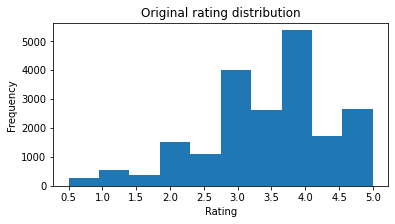

In [36]:
plt.figure(figsize=(6,3))
plt.title('Original rating distribution')
plt.xlabel('Rating')
plt.xticks(np.arange(0, 6, 0.5))
df_predictions.rating.plot.hist(bins=10)

<AxesSubplot:title={'center':'GNN rating distribution'}, xlabel='Rating', ylabel='Frequency'>

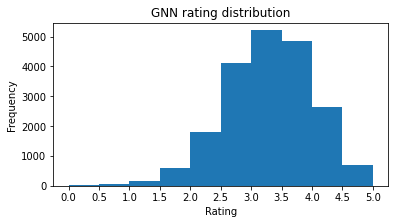

In [37]:
plt.figure(figsize=(6,3))
plt.title('GNN rating distribution')
plt.xlabel('Rating')
plt.xticks(np.arange(0, 6, 0.5))
df_predictions.prediction.plot.hist()

<AxesSubplot:title={'center':'MSE Loss distribution'}, xlabel='mse', ylabel='Frequency'>

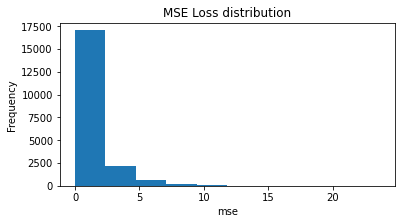

In [38]:
plt.figure(figsize=(6,3))
plt.title('MSE Loss distribution')
plt.xlabel('mse')
df_predictions.mse_loss.plot.hist()